# deepSSAM prototype notebook

This notebook contains a prototype implementation of a deepSSAM neural network algorithm that uses a pre-trained neural network to generalize gene expression information to FITC/DAPI technology information.

#### Imports:

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata


#### Parameter definition:

In [4]:
img_path_wall = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_Cellbound3_z4.tif'
img_path_dapi = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_DAPI_z4.tif'
coordinate_path = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/detected_transcripts.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [5]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


In [6]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

df.columns=['x','y','z','gene']

df.x-=df.x.min()
df.y-=df.y.min()
df.x/=um_per_pixel/scale
df.y/=um_per_pixel/scale

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

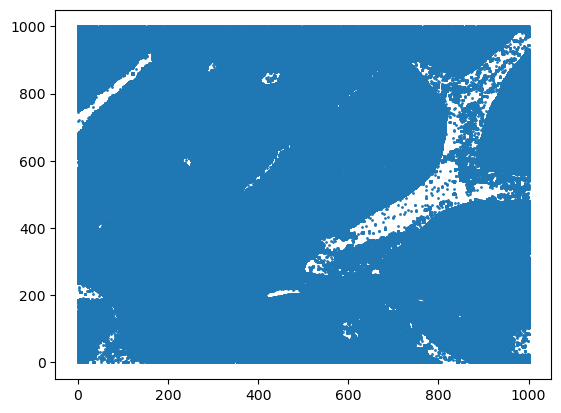

In [7]:
#

x_lims = [1000,2000]
y_lims = [1000,2000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask]

df.x-=df.x.min()
df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1)


In [8]:
from src import ovrlp

roi_df = ovrlp.find_overlaps(df,min_distance=10)

roi_df

,x,y,divergence
0,0,69,160.545038
1,0,240,203.003578
2,0,401,178.870591
3,0,573,175.757931
4,6,550,193.447194
...,...,...,...
439,999,758,156.056585
440,999,868,198.695994
441,999,918,198.246954
442,999,924,189.369315


[ 19 107 107 ... 159 315 165]
Plotting case 0


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should 

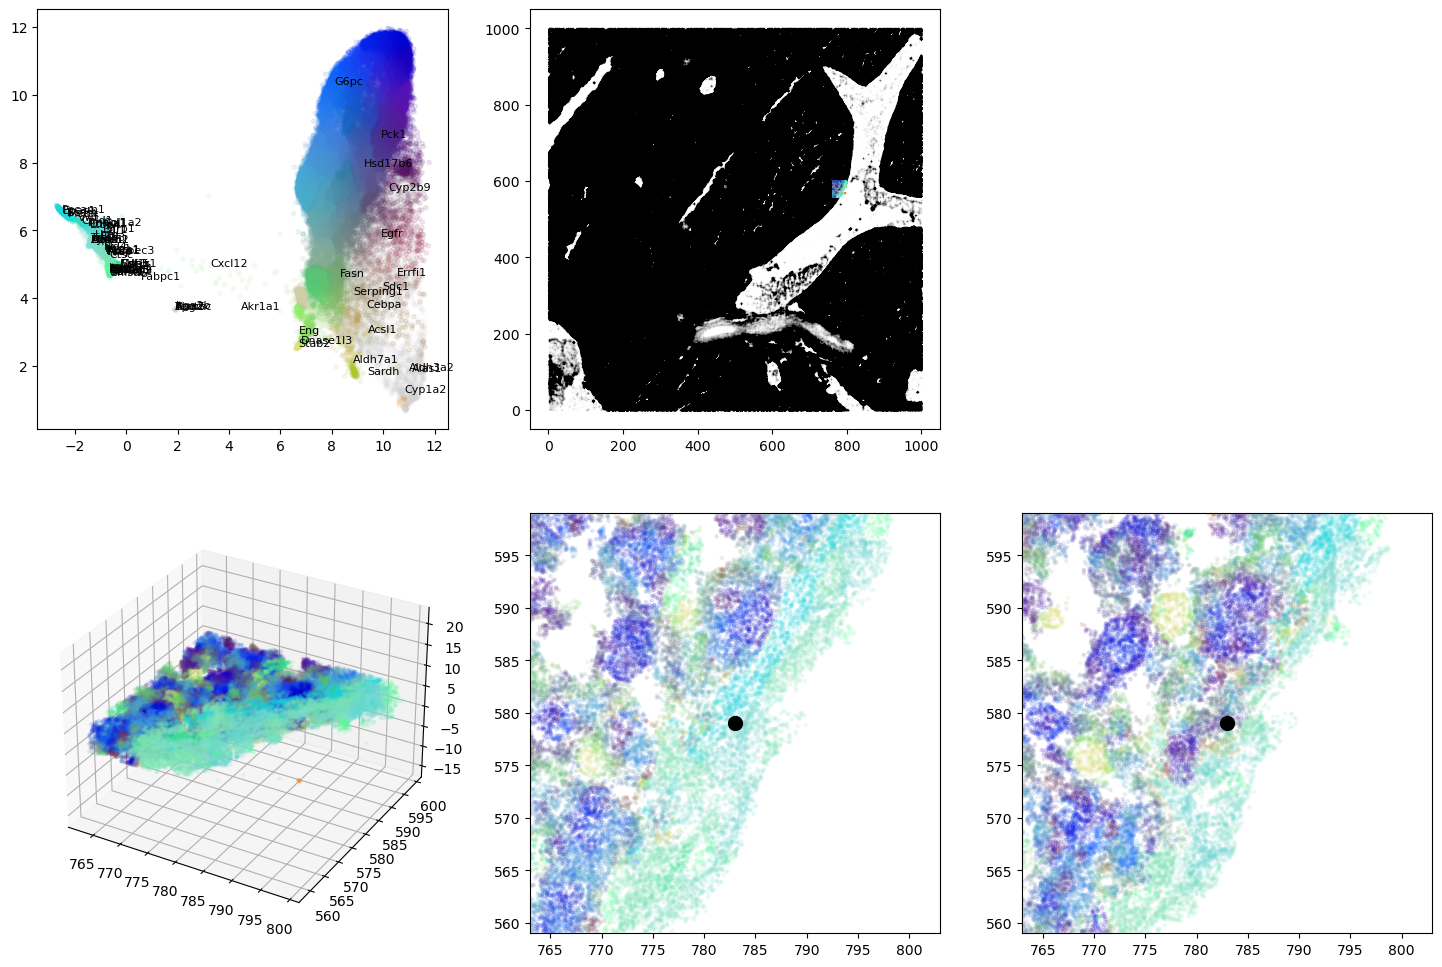

In [9]:

ovrlp.visualize_rois(df,roi_df, signature_matrix = None,
                     celltyping_min_expression=5,
                     n_cases=[0,1,2,3,4]+list(range(5,100,15)),plot_window_size=20)

#### Loading image data:

In [10]:

from PIL import Image

Image.MAX_IMAGE_PIXELS =10e10

img_=Image.open(img_path_wall)#[:4000,:4000]
img_=(np.array(img_.resize((np.array(img_.size)*scale).astype(int)),)[...,None]/256).astype("uint8")
print(img_.max())

img_ = np.concatenate((np.zeros_like(img_),img_, (np.array(Image.open(img_path_dapi).resize(img_.shape[1::-1]))[...,None]/256).astype("uint8")),axis=-1,dtype='uint8')
# img_ = img_[:2000,:2000]

img=img_.copy()
# img = np.array(img)

# del img_

plt.imshow(img_)

255


Error in callback <function _draw_all_if_interactive at 0x7f6357d089d0> (for post_execute):


KeyboardInterrupt: 

#### Apply spatial equalizer to the image. 

In [ ]:

from scipy import ndimage

img=img_.copy()

# walls_hpf = np.fft.ifft2(ndimage.fourier_gaussian(np.fft.fft2(img_[:,:,1]), sigma=100)).real
# walls_hpf = img_[:,:,1]/(walls_hpf+0.1)
# walls_hpf=walls_hpf**0.8
# walls_hpf/=walls_hpf.max()/4000
# walls_hpf[walls_hpf>256]=255
# img[:,:,1]= (walls_hpf).astype("uint8")

# dapi_hpf = np.fft.ifft2(ndimage.fourier_gaussian(np.fft.fft2(img_[:,:,2]), sigma=100)).real
# dapi_hpf = img_[:,:,2]/(dapi_hpf+0.1)
# dapi_hpf = dapi_hpf**0.8
# dapi_hpf/=dapi_hpf.max()/3000
# dapi_hpf[dapi_hpf>256]=255
# img[:,:,2]= (dapi_hpf).astype("uint8")

img = img.transpose((1,0,2))

del img_

In [ ]:
# img_val = img[img.shape[1]:,:img.shape[1]]
# img_train =  img[:img.shape[1],:img.shape[1]]

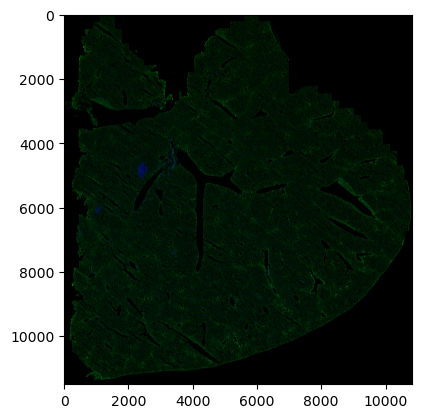

In [ ]:
plt.figure()
plt.imshow(img)